# CSX46 Homework 1

Fanghai Ge 933669678

The human metabolic network is made available in edge-list format in a two-column tab-delimited text file `shared/hsmetnet.txt`.  In case you want to check that you have a complete and uncorrupted version of the file, here is it's MD5 checksum: `50bc7295c1f727cdc5867e4853a27583`. An example of the `hsmetnet.txt` file format is shown here:
```
alkylated DNA   REACTION1
REACTION1       DNAn
REACTION1       alkylated nucleobase
acetyl-CoA      REACTION2
1-alkyl-2-lyso-sn-glycero-3-phosphocholine      REACTION2
REACTION2       1-alkyl-2-acetyl-sn-glycero-3-phosphocholine
REACTION2       coenzyme A
deoxyribonucleoside triphosphate        REACTION3
(deoxynucleotides)(n)   REACTION3
```
You will see that there are two types of nodes; nodes that start with `REACTION` and nodes that do not. The former represent chemical *reactions*, and the latter represent *metabolites*. This graph is directed, so the ordering of the nodes is important; a row of the form
```
some-metabolite    REACTION523
```
is saying that metabolite `some-metabolite` is an *input* to (i.e., a reactant for) reaction `REACTION523`. Conversely, a row of the form
```
REACTION634    another-metabolite
```
is saying that metabolite `another-metabolite` is an *output* of (i.e., a product of) reaction `REACTION634`. A graph with two classes of nodes (and for which the only allowed edges are *between* nodes of the two classes, never *among* nodes of a single class) is called *bipartite*. So in this homework assignment we will be analyzing the human metabolic network as a bipartite graph.

You will need to submit your homework assignment as either a Jupyter notebook (preferred) or a PDF of a report showing both code *and* results from running the code. 

Your first step is to read in the metabolic network as an edge-list (hint: use `read_csv` from `pandas`). Name the two columns `source` and `target`.

In [1]:
import pandas
import igraph
import numpy

In [2]:
meta = pandas.read_csv("shared/hsmetnet.txt",
                                 sep="\t", 
                                 names=["source","target"])

Next, you will want to construct a list of the names of all vertices and construct a list of indexes of vertices that are metabolites (hint: use `Graph.TupleList` with `directed=True`; you can use  `.values.tolist()` on the Pandas dataframe

In [3]:
meta_graph = igraph.Graph.TupleList(meta[["source","target"]].values.tolist(), directed=True)
meta_graph.summary()

'IGRAPH DN-- 7879 19708 -- \n+ attr: name (v)'

Questions for you: *how many distinct metabolites are there in the graph?* *How many reactions?* *How many edges are there?* 

(hint: use list comprehension, `in`, `for`, `len`, `str`, `set`, and `shape`)

In [4]:
meta_inds = []
cont = 0
for v in meta_graph.vs:
    if "REACTION" in v["name"]:
        cont += 1
    else:
        meta_inds.append(v.index)
N = len(meta_graph.vs)
metanum = len(meta_inds)
print("number of distinct metabolites in the graph:", metanum)
print("number of distinct reactions in the graph: ", cont)

meta_edges = meta_graph.get_edgelist()
edges = len(meta_edges)
print("number of edges in the graph:", edges)

number of distinct metabolites in the graph: 2340
number of distinct reactions in the graph:  5539
number of edges in the graph: 19708


Question for you: In this graph, what are the top six metabolites in terms of vertex degree?

(hint: use list comprehension, `for`, `enumerate`, `sorted` (with `reverse=True`), and `lambda` or `itemgetter`)

Thank you to Lindsey Kvarfordt for helping revise this code (SAR)

In [5]:
from collections import defaultdict
degree = defaultdict(int)
for v in meta_graph.vs:
    if "REACTION" in v["name"]:
        continue
    else:
        degree[v["name"]] = v.degree()
from operator import itemgetter
sorted_degree = sorted(degree.items(), key=itemgetter(1), reverse=True)
meta_name = []
for i in range(6):
    meta_name.append(sorted_degree[i][0])
print(meta_name)

['ATP', 'ADP', 'phosphate', 'peptide', '[protein] (L-serine/L-threonine) phosphate', '[protein]-(L-serine/L-threonine)']


Assignment for you: *Plot the distribution of the degrees of these vertices, on log-log scale.*  

(hint: use `degree_distribution` in igraph, with `vertices=metabolite_inds`; use the `.bins()` method to get the bin counts out; you can use `matplotlib.pyplot.loglog` to plot). As your "x" coordinate, please use the `left` element of the histogram bins (see the Class 3 degree distance python notebook).

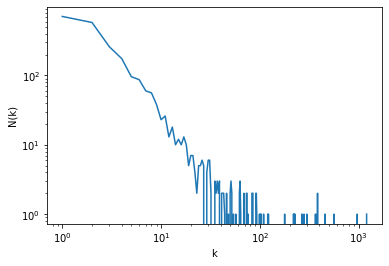

In [6]:
import matplotlib.pyplot as plt
xs, ys = zip(*[(left, count) for left, _, count in 
         meta_graph.degree_distribution(vertices = meta_inds).bins()])
plt.loglog(xs, ys)
plt.xlabel("k")
plt.ylabel("N(k)")
plt.show()

Question: *what is the exponent α of the best-fit power-law to the degree distribution?* 

(hint: use `igraph.statistics.power_law_fit`)

In [7]:
print("%.2f" % igraph.statistics.power_law_fit(meta_graph.degree(meta_inds)).alpha)

2.02


Questions to answer: *How does the α that you get compare to the estimate of the power-law exponent reported by Jeong et al. in their 2000 article in Nature, “The large-scale organization of metabolic networks” (vol. 407, pp. 651–654) (see page 14 of reading-for-class-06.pdf)? Based on structure of the network that you analyzed (bipartite, containing reactions) vs. the structure of the network that they analyzed (network projected to a network containing only metabolites), is it appropriate to compare the exponents? Why or why not?*

Answer: I think the α that I get is not have much different with jeong et al. beacuse it all comes from the degree distribution of the metabolites. And i think it approporite to compare the exponents because it's containing reactions and bipartite is more efficent to analyse the dgree contribution. 

Task:  *Calculate the shortest-path-lengths between all pairs of metabolites (vertices) in the giant weakly connected component of the graph, discarding direction information in the graph.*  

(hint: use `clusters` with `mode=weak` to get the giant weakly-connected component; then use `components.membership` and `enumerate` to get the giant component members; then use `igraph.shortest_paths` with `mode=igraph.ALL`, with
`source=<metabolite_vertex_indices>` and `target=<metabolite_vertex_indices>` to get the
all-pairs-shortest-paths.)

In [8]:
meta_components = meta_graph.clusters(mode = "weak")

meta_component_sizes = meta_components.sizes()

inds_giant_component =  [index for index, item in enumerate(meta_components.membership) if item==numpy.argmax(meta_component_sizes)]

numpy.set_printoptions(suppress=True)

meta_inds_giant = numpy.array([], dtype = numpy.int64)

meta_inds_array = numpy.array(meta_inds)

for index in inds_giant_component:
    meta_inds_giant = numpy.hstack((meta_inds_giant, meta_inds_array[meta_inds_array == index]))

apsp_dists = meta_graph.shortest_paths(source = meta_inds_giant,
                                       target = meta_inds_giant,
                                       mode = igraph.ALL)

Question: *What is the average of the shortest-path-lengtsh between all pairs of metabolites in the giant (weakly connected) component of the network?*

 

(hint: Use `numpy.array`, `numpy.isfinite` and `numpy.mean` to get the mean distance; throw away any shortest-paths distance value if it is infinite.)

In [9]:
apsp_array = numpy.array(apsp_dists)
print("%0.2f" % numpy.mean(apsp_array))

6.80


Question: *What is the maximum of the shortest-path-length between all pairs of metabolites (throwing away infinite values, as before) in the giant (weakly connected) component of the network?* 

(hint: use `numpy.max` and `numpy.isfinite`; Note, you are calculating the diameter of the giant component)

In [10]:
print(numpy.max(apsp_array))

18


Question:  *Why are the average geodesic distances that we get, roughly twice those reported in Fig. 3b of Jeong et al., 2000?*

because we use the igraph.all it will change directed edge into undirected edge

Calculate the shortest-paths betweenness centrality for all metabolites in the directed network.  (hint: use the `betweenness` function with the `v=<vector of vertex indices>` option, with `directed=True`)

In [11]:
meta_betweenness = meta_graph.betweenness(vertices = meta_inds, directed = True)
meta_betweenness_max = numpy.max(meta_betweenness)
meta_betweenness_min = numpy.min(meta_betweenness)
for i in range(len(meta_betweenness)):
    meta_betweenness[i] = (meta_betweenness[i] - meta_betweenness_min) / (meta_betweenness_max - meta_betweenness_min)

Task: *plot the scatter plot of betweenness centrality vs. vertex degree for all metabolites, on log-log scale.* 

(hint:  use `numpy.array`, `numpy.where`, and `matplotlib.pyplot.scatter`)

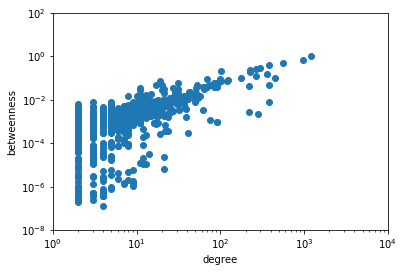

In [12]:
degree_array = numpy.array(meta_graph.degree(meta_inds))
ax = plt.gca()
ax.scatter(degree_array, meta_betweenness)
ax.set_xscale("log")
ax.set_yscale("log")
plt.xlabel("degree")
plt.ylabel("betweenness")
plt.ylim(0.00000001, 100)
plt.xlim(1, 10000)
plt.show()

Question: *Among metabolites with degree k=2 , what metabolite has highest betweenness centrality in the network?* 

(hint:  use `numpy.argmax` and `numpy.where`

In [13]:
inds_2_v = []
degree_all = numpy.array(meta_graph.degree())
inds_2_temp = numpy.where(degree_all == 2)[0]
inds_2 = numpy.array(inds_2_temp)
n = 0
for i in inds_2:
    if "REACTION" in meta_graph.vs[i]["name"]:
        n = n + 1
    else:
        inds_2_v.append(i)


In [14]:
meta_betweenness_2 = meta_graph.betweenness(vertices = inds_2_v, directed = True)
meta_betweenness_2_array = numpy.array(meta_betweenness_2)
meta_betweenness_2_max = numpy.max(meta_betweenness_2_array)
inds_2_max = [index for index, i in enumerate(meta_betweenness_2_array) if i == meta_betweenness_2_max ]
meta_graph.vs[inds_2_v[numpy.argmax(meta_betweenness_2_array)]]["name"]

'L-arginino-succinate'

Search on this metabolite in the HumanCyc database at [humancyc.org](https://humancyc.org), using the search box. Click on the "reactions" tab. What important metabolic cycles is this metabolite involved in? Click on the "urea cycle". What is the known consequence of absence of an enzyme in this pathway?

L-aspartate + L-citrulline + ATP → L-arginino-succinate + AMP + diphosphate + H+
argininosuccinate synthase [ASS1]